In [738]:
import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import re
tr = pd.read_csv('train.csv',dtype={'Age': np.float64})
te = pd.read_csv('test.csv',dtype={'Age': np.float64})


tr.drop(['PassengerId'], axis=1,inplace=True)
%matplotlib inline

## List of features:

- survival -> Survived (0,1)
- pclass -> Ticket Class (1,2,3)
- sex	-> Sex	
- Age	-> Age in years	
- sibsp -> # of siblings / spouses aboard the Titanic	
- parch -> # of parents / children aboard the Titanic	
- ticket -> Ticket number	
- fare -> Passenger fare	
- cabin -> Cabin number

## Checking the types of features

In [739]:
tr.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

## Checking for null and missing values

In [740]:
tr.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## Describing data

In [741]:
tr.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Bourke, Mr. John",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## Checking the correlation between features

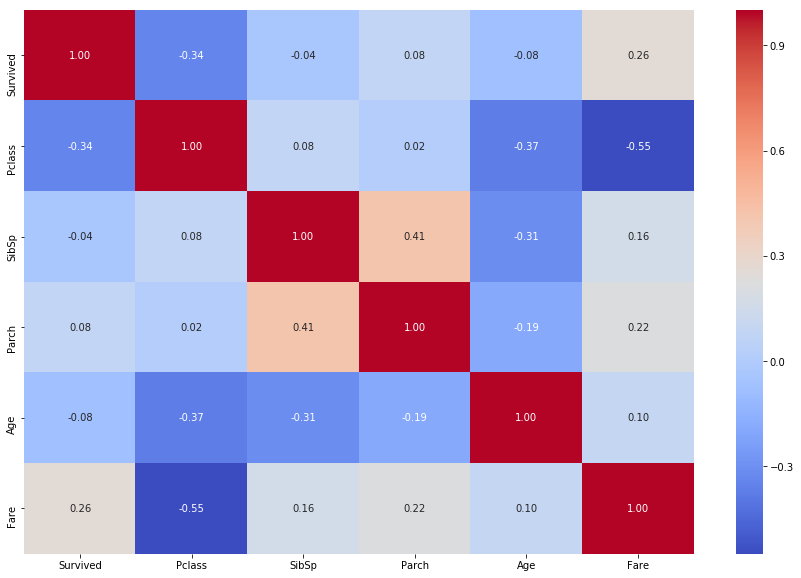

In [742]:
plt.subplots(figsize=(15,10))
sns.heatmap(tr[["Survived","Pclass","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# Visualization

## Sex vs mean(Survived)

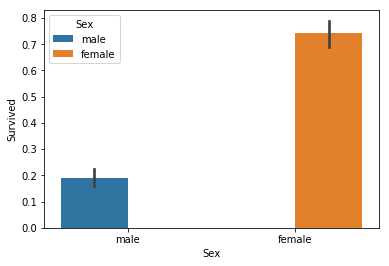

In [743]:
sns.barplot('Sex', 'Survived', hue="Sex",data=tr)

The Plot shows that females had a better chance of survival that males.

## Embarked

### We fill the missing values with 'C' because it's the most common on the data, then we transform embarked into Dummy Variables

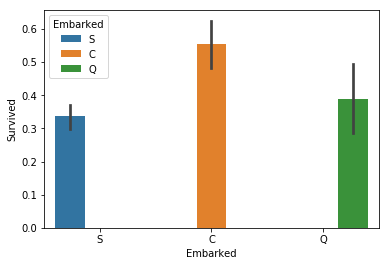

In [744]:
sns.barplot('Embarked', 'Survived', hue="Embarked",data=tr)
tr.loc[ (tr.Embarked.isnull()), 'Embarked' ] = 'C'
tr = pd.get_dummies(tr, columns=['Embarked'],drop_first=True)

## Cabin

### Since Cabin has a lot of NaN numbers (687 out of 891), it will not strongly impact our prediction.
### Therefore we drop Cabin

In [745]:
tr.drop(['Cabin'], axis=1,inplace=True)

## Name

### Name does not contribute to our prediction. One's survival does not depends on his/her name. We drop name.

In [746]:
tr.drop(['Name'], axis=1,inplace=True)

## Ticket

### Ticket may be dropped because it has 23% duplicate data, and its not strongly correlated with survival rates. 

In [747]:
tr.drop(['Ticket'], axis=1,inplace=True)

## SibSp 

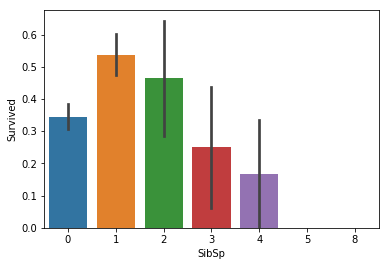

In [748]:
sns.barplot('SibSp', 'Survived',data=tr)

## We can infer from the above plot that people who traveled alone or with less siblings (1-2) had a better survival rate

## Parch

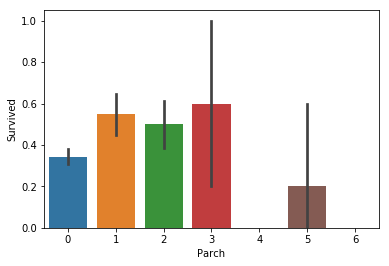

In [749]:
sns.barplot('Parch', 'Survived',data=tr)

## Parch is similar to SibSp and it can also make sense to combine the two fields.

## Age

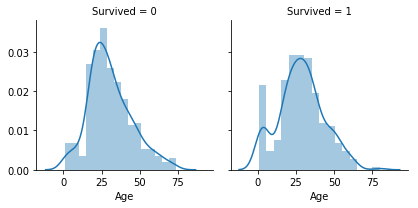

In [750]:
age = sns.FacetGrid(tr, col='Survived')
age.map(sns.distplot, "Age")

## Children younger than 10 had better survival rate. Large number of 15-25 year olds didn't survive.

## Pclass

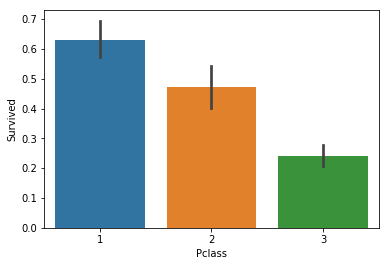

In [751]:
sns.barplot('Pclass', 'Survived',data=tr)

### People with better Pclass survived (possibly due to better safety equipment/priority assistance).

## Fare

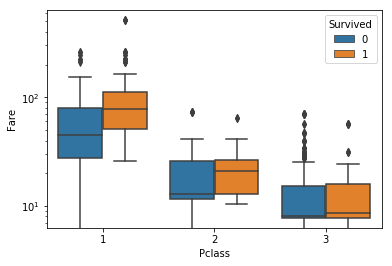

In [752]:
sns.boxplot(x="Pclass", y="Fare", hue="Survived", data=tr).set_yscale('log')

### People who paid more had a better chance of survival (correlation with Pclass).

# Feature Engineering

## Combining SibSp and Parch

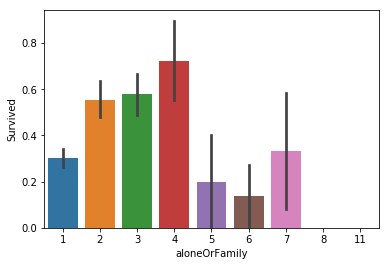

In [753]:
tr['aloneOrFamily'] = tr['SibSp'] + tr['Parch'] + 1
sns.barplot('aloneOrFamily', 'Survived',data=tr)

### Travelling with family (1-3 people) give you better chance of survival

In [754]:
tr.drop(['SibSp','Parch'], axis=1,inplace=True)

## Sex

### We need to convert 'male' and 'female' to numeric values (encoding categorical data).

In [755]:
tr.loc[tr.Sex=='male','Sex'] = 1
tr.loc[tr.Sex=='female','Sex'] = 0

## Age

### There are 177 missing values that we need to fill in

 - We will use Random Forest to predict ages (retrieved from Kernel: https://www.kaggle.com/poonaml/titanic-survival-prediction-end-to-end-ml-pipeline) 

In [756]:
from sklearn.ensemble import RandomForestRegressor
#predicting missing values in age using Random Forest
def fill_missing_age(df):
    
    #Feature set
    age_df = df[['Age','Fare', 'aloneOrFamily',
                 'Pclass','Sex']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Age.notnull()) ]# known Age values
    test = age_df.loc[ (df.Age.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df
tr=fill_missing_age(tr)

In [757]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(tr[['Age', 'Fare']])
tr[['Age', 'Fare']] = std_scale.transform(tr[['Age', 'Fare']])

In [758]:
result = tr['Survived']
tr.drop(['Survived'], axis=1,inplace=True)
X_train,X_test,Y_train,Y_test = train_test_split(tr,result,random_state=0)

## Predicting

# Test with test.csv

In [759]:
te.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [760]:
te.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
te = pd.get_dummies(te,columns=['Embarked'],drop_first=True)

In [761]:
te.loc[te.Sex=='male','Sex'] = 1
te.loc[te.Sex=='female','Sex'] = 0

## Age and Fare have missing values


In [762]:
def fill_missing_fare(df):
    
    #Feature set
    age_df = df[['Fare','Parch','SibSp',
                 'Pclass','Sex']]
    # Split sets into train and test
    train  = age_df.loc[ (df.Fare.notnull()) ]# known Age values
    test = age_df.loc[ (df.Fare.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.Fare.isnull()), 'Fare' ] = predictedAges 
    
    return df
te = fill_missing_fare(te)
te['aloneOrFamily'] = te['SibSp'] + te['Parch'] + 1
te.drop(['SibSp','Parch'],axis=1,inplace=True)

In [763]:
te = fill_missing_age(te)

In [764]:
passengerId = te['PassengerId']
te.drop(['PassengerId'],axis=1,inplace=True)
std_scale = preprocessing.StandardScaler().fit(te[['Age', 'Fare']])
te[['Age', 'Fare']] = std_scale.transform(te[['Age', 'Fare']])

In [768]:
def getClassifierWithHighestAccuracy():
    classifiers = [
    KNeighborsClassifier(15),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]
    models = pd.DataFrame({'Model':[],'Score':[]})
    i=0
    greater = 0
    alg = ''
    for clas in classifiers:
        clas.fit(X_train,Y_train)
        models.loc[i]=[clas.__class__.__name__,str(accuracy_score(Y_test,clas.predict(X_test))*100)+' %']
        if accuracy_score(Y_test,clas.predict(X_test))*100 > greater:
            greater = accuracy_score(Y_test,clas.predict(X_test))*100
            alg = clas
        i+=1
    print(models.sort_values(by=['Score'],ascending=False))
    return alg


                           Model                Score
5     GradientBoostingClassifier  85.20179372197309 %
0           KNeighborsClassifier  82.51121076233184 %
1                            SVC   82.0627802690583 %
3         RandomForestClassifier   82.0627802690583 %
6                     GaussianNB  80.26905829596413 %
9             LogisticRegression  79.82062780269058 %
7     LinearDiscriminantAnalysis  79.37219730941703 %
8  QuadraticDiscriminantAnalysis  79.37219730941703 %
4             AdaBoostClassifier   78.9237668161435 %
2         DecisionTreeClassifier  77.13004484304933 %


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [766]:
import sys
model = getClassifierWithHighestAccuracy()
model.fit(X_train,Y_train)
print(accuracy_score(Y_test,model.predict(X_test)))
predictions = model.predict(te)
orig_stdout = sys.stdout
f = open('out.csv', 'w')
sys.stdout = f
print('PassengerId,Survived')
for i in range(len(predictions)):
    print(passengerId[i],end="")
    print(',',end="")
    print(predictions[i])
sys.stdout = orig_stdout
f.close()

0.852017937219731
